In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import auc
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score


In [3]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


def ROC(label, y_prob):
    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point
    

In [4]:
# Data Loading
f = r'C:\Users\User\VSCode\CDSS_report_mdro_info.xlsx'

CDSS = pd.read_excel(f, dtype={'病歷號碼':'str'})
# m = CDSS[CDSS.openTime==CDSS.minTime]

In [5]:
CDSS.Group_Strain.value_counts()

Enterococcus faecium       245
Klebsiella pneumoniae      228
Escherichia coli           190
Staphylococcus aureus      169
Pseudomonas aeruginosa     163
Acinetobacter baumannii    145
Enterobacter cloacae        18
Morganella morganii          9
Name: Group_Strain, dtype: int64

In [84]:

## add column 'Resistance'
CDSS = CDSS[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', 'Age', '抗藥性菌株', 'examTime',
         'reportTime', 'openTime', '菌株', 'PredValue', 'sendTime', 'Group_Strain', 'PredLevel', 'Resist_bool']].drop_duplicates() 

# Strain 
SA = CDSS[CDSS.Group_Strain=='Staphylococcus aureus'].reset_index(drop=True)
EF = CDSS[CDSS.Group_Strain=='Enterococcus faecium'].reset_index(drop=True)
KP = CDSS[CDSS.Group_Strain=='Klebsiella pneumoniae'].reset_index(drop=True)
EC = CDSS[CDSS.Group_Strain=='Escherichia coli'].reset_index(drop=True)
PA = CDSS[CDSS.Group_Strain=='Pseudomonas aeruginosa'].reset_index(drop=True)
AB = CDSS[CDSS.Group_Strain=='Acinetobacter baumannii'].reset_index(drop=True)
MM = CDSS[CDSS.Group_Strain=='Morganella morganii'].reset_index(drop=True)
ECL = CDSS[CDSS.Group_Strain=='Enterobacter cloacae'].reset_index(drop=True)
# Resist
SA['Resist'] = np.where(SA['Resist_bool']==True, 'MRSA', 'MSSA')
# SA['Resist_bool'] = np.where(SA['Resist']=='MRSA', 1, 0)
# SA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# # scatter plot

# plt.figure(figsize=(16, 9))
# sn.set(font_scale = 1.5)
# plt.title('Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
# # Acinetobacter baumannii   AB  CRAB    CSAB
# # Staphylococcus aureus     SA	MRSA	MSSA
# # Escherichia coli          EC	CREC	CSEC
# # Pseudomonas aeruginosa    PA	CRPA	CSPA
# # Klebsiella pneumoniae     KP	CRKP	CSKP
# # Morganella morganii       MM	CRMM	CSMM
# # Enterococcus faecium      EF	VRE	VSE

# ax = sn.scatterplot(data=SA, x="PredValue", y="Age", hue="Resist")
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# # plt.legend(loc='upper right')
# # sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

# plt.show()


# distribution
print('Strain: Staphylococcus aureus (Jan-Mar 2022)')
print('Amount:', SA['病歷號碼'].count())
print('Patient:', SA['病歷號碼'].drop_duplicates().count())
print()
print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
SA.groupby('PredLevel')['PredValue'].describe()



Strain: Staphylococcus aureus (Jan-Mar 2022)
Amount: 149
Patient: 95

PredLevel  Resist
0~20%      MRSA      14
           MSSA      35
21~40%     MRSA       2
           MSSA       2
41~60%     MRSA       2
           MSSA       2
61~80%     MRSA       5
           MSSA       5
81~100%    MRSA      68
           MSSA      14
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,49.0,9.000000,4.541476,0.0,10.00,10.0,10.00,19.0
21~40%,4.0,26.750000,4.573474,22.0,23.50,26.5,29.75,32.0
41~60%,4.0,55.250000,4.425306,51.0,51.75,55.0,58.50,60.0
61~80%,10.0,72.800000,6.142746,64.0,67.50,73.0,78.50,80.0
81~100%,82.0,98.426829,2.981550,84.0,99.00,99.0,100.00,100.0


<function matplotlib.pyplot.show(close=None, block=None)>

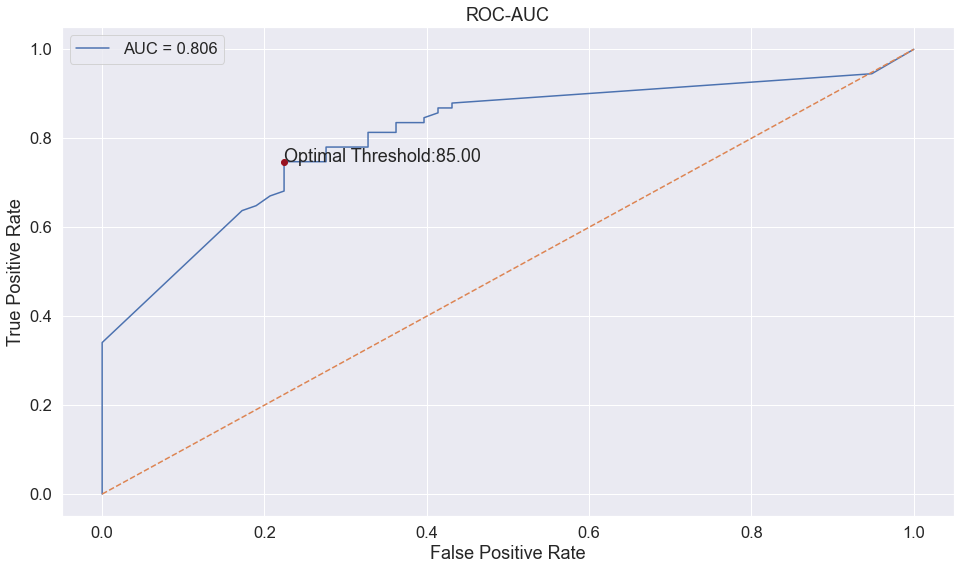

In [85]:
# Create the ROC curve
# fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)

fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(SA['Resist_bool'], SA.PredValue)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker="o", color="#981220")
plt.text(optimal_point[0], optimal_point[1], f'Optimal Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show

Best Threshold: 85 with G-Mean: 0.7614
FPR: 0.2241, TPR: 0.7473


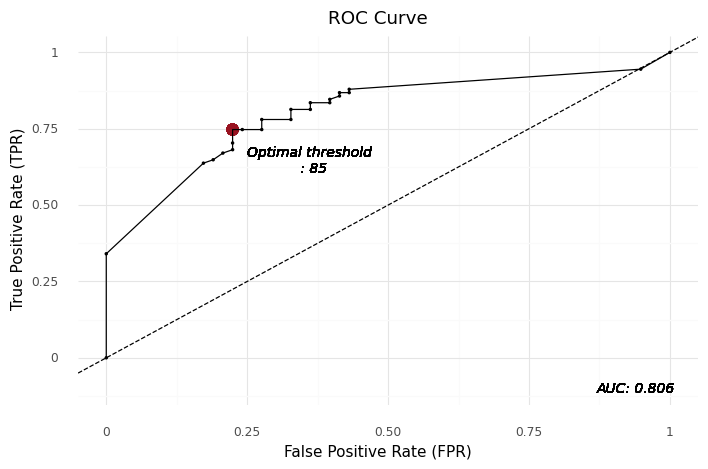

<ggplot: (139931967952)>

In [86]:
# Import module for data visualization
from plotnine import *
import plotnine

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Threshold  MRSA  MSSA
Actual               
MRSA         68    23
MSSA         13    45


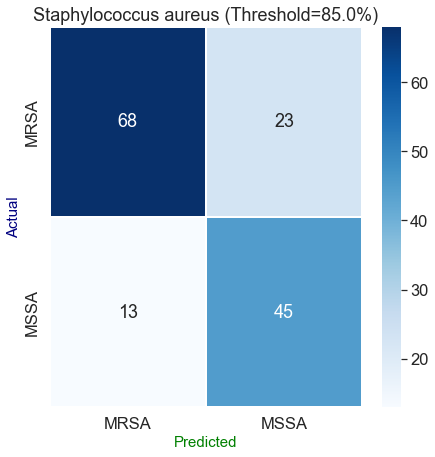

In [123]:
# confusion matrix
SA['Threshold'] = np.where(SA.PredValue >= optimal_th, 'MRSA', 'MSSA')
# SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['Threshold'], rownames=['Actual'], colnames=['Threshold'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5, cmap='Blues')
plt.title(f'Staphylococcus aureus (Threshold={optimal_th:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

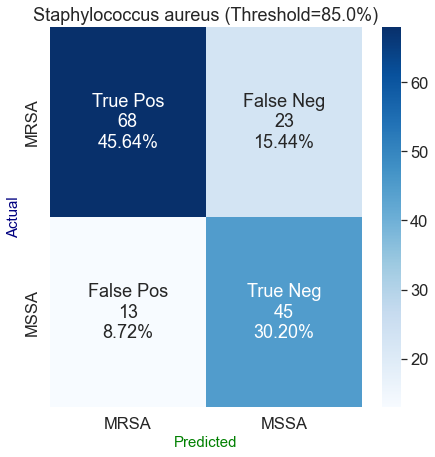

In [40]:
plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
group_names = ['True Pos','False Neg','False Pos','True Neg'] 
# labels = np.asarray(labels).reshape(2,2)
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_SA.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_SA.to_numpy().flatten()/np.sum(confusion_matrix_SA.to_numpy())]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(confusion_matrix_SA, annot=labels, fmt='', cmap='Blues')
plt.title(f'Staphylococcus aureus (Threshold={optimal_th:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

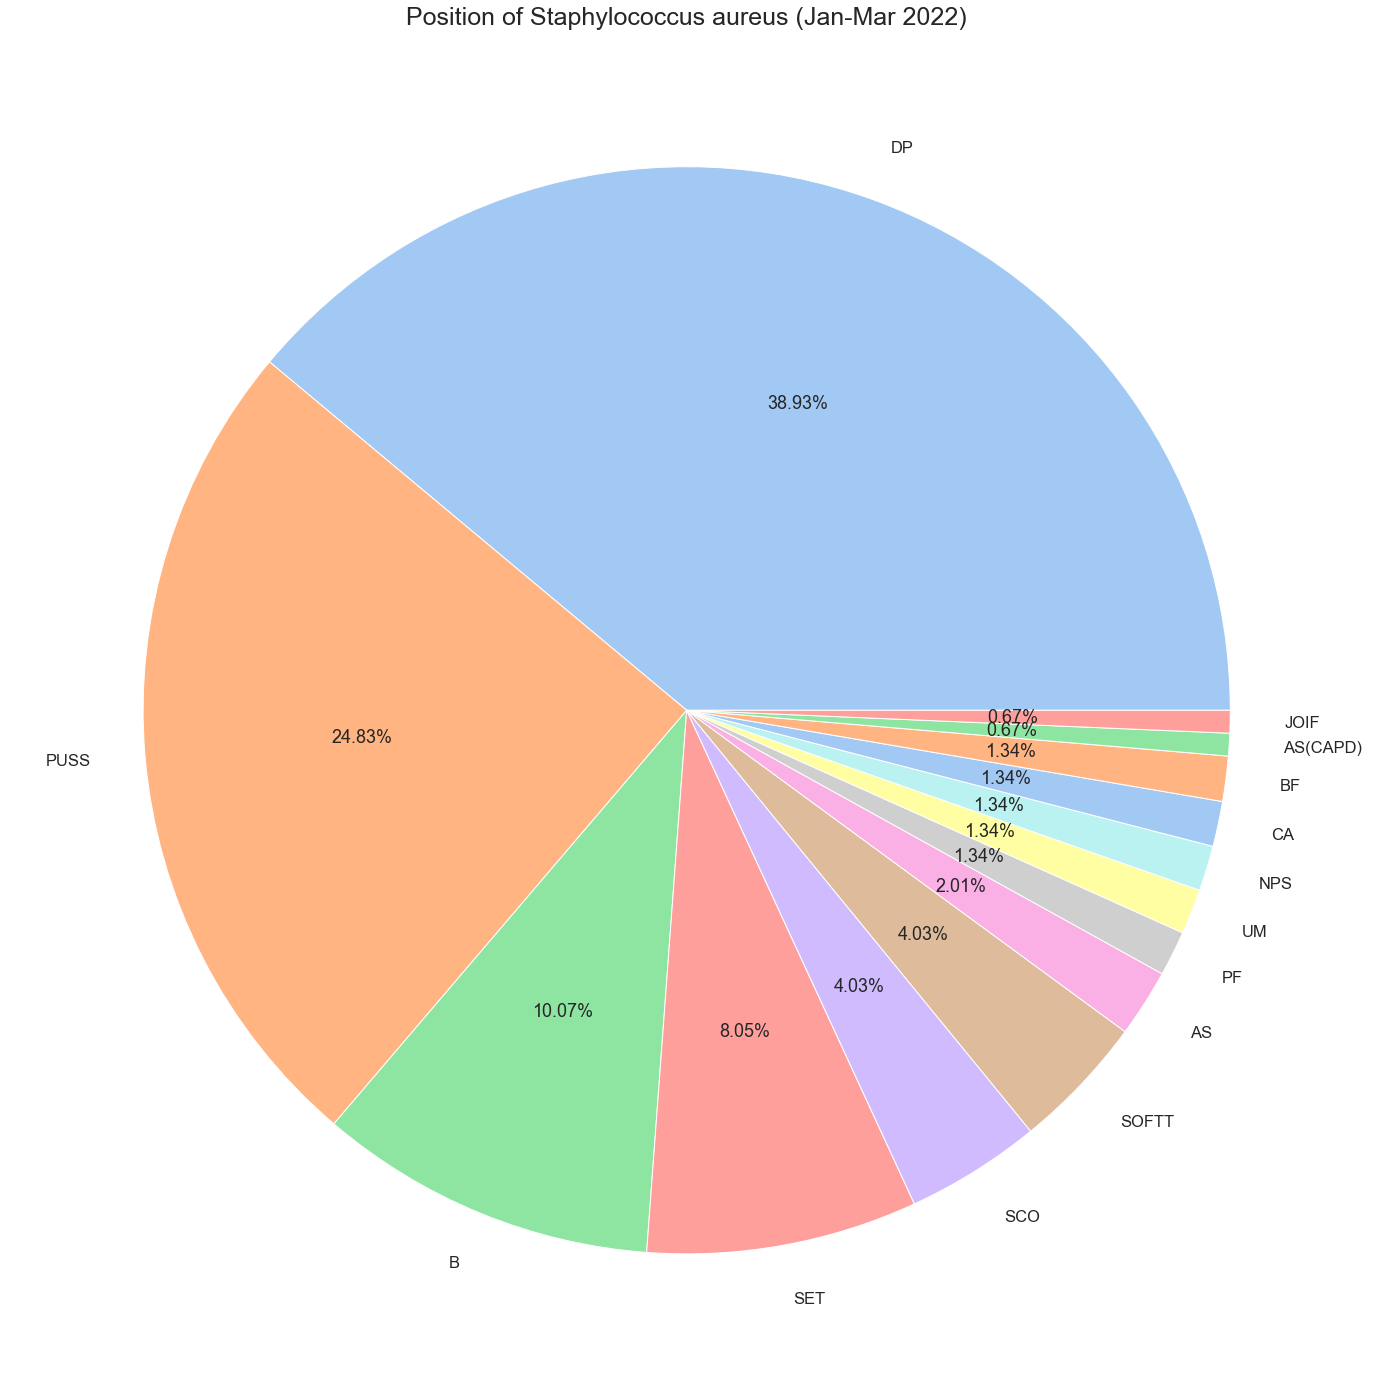

In [8]:
pieData = SA['部位'].value_counts()
label = pieData.index

colors = sn.color_palette('pastel')

#create pie chart
sn.set(font_scale = 1.5)
plt.figure(figsize=(25,25))
plt.pie(pieData, labels = label, autopct='%.2f%%', colors=colors)
plt.title('Position of Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
plt.show()

In [53]:
# confusion matrix

for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    for t in range(10, 100, 10):
        s['Threshold'] = np.where(s.PredValue >= t, True, False)
        # SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
        confusion_matrix = pd.crosstab(s['Resist_bool'], s['Threshold'], rownames=['Actual'], colnames=['Threshold'])
        # print (confusion_matrix)
        
        # plt.figure(figsize=(7,7))
        # sn.set(font_scale = 1.5)
        # sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
        # plt.title(f'{s.Group_Strain[0]} (Threshold={t:.1f}%)', fontsize = 18)
        # plt.xlabel('Predicted', fontsize = 15, color='green')
        # plt.ylabel('Actual', fontsize = 15, color='navy')
        
        # plt.savefig(r"C:\Users\User\VSCode\LULU\ConfusionMatric\\{}.png".format(s.Group_Strain[0] + str(t)))
        
        # plt.figure(figsize=(7,7))
        # sn.set(font_scale = 1.5)
        # group_names = ['True Pos','False Neg','False Pos','True Neg'] 
        # # labels = np.asarray(labels).reshape(2,2)
        # group_counts = ["{0:0.0f}".format(value) for value in
        #                 confusion_matrix_SA.to_numpy().flatten()]
        # group_percentages = ["{0:.2%}".format(value) for value in
        #                     confusion_matrix_SA.to_numpy().flatten()/np.sum(confusion_matrix_SA.to_numpy())]
        # labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        #         zip(group_names,group_counts,group_percentages)]
        # labels = np.asarray(labels).reshape(2,2)
        # sn.heatmap(confusion_matrix_SA, annot=labels, fmt='', cmap='Blues')
        # plt.title(f'{s.Group_Strain[0]} (Threshold={t:.1f}%)', fontsize = 18)
        # plt.xlabel('Predicted', fontsize = 15, color='green')
        # plt.ylabel('Actual', fontsize = 15, color='navy')
        # plt.show()

Threshold  False  True
Actual                
False          3    55
True           5    86
Threshold  False  True
Actual                
False         35    23
True          14    77
Threshold  False  True
Actual                
False         37    21
True          15    76
Threshold  False  True
Actual                
False         37    21
True          16    75
Threshold  False  True
Actual                
False         37    21
True          16    75
Threshold  False  True
Actual                
False         39    19
True          17    74
Threshold  False  True
Actual                
False         41    17
True          20    71
Threshold  False  True
Actual                
False         42    16
True          23    68
Threshold  False  True
Actual                
False         45    13
True          25    66
Threshold  False  True
Actual                
False          5    79
True          10   139
Threshold  False  True
Actual                
False         18    66
True       

In [107]:
# sensitive = {'Strain':[], 'Threshold':[], 'Value':[]}
Strain = []
Threshold = []
Sensitivity = []
Specificity = []
Positive_predictive_value = []
Negative_predictive_value = []

for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    for t in range(10, 100, 10):
        s['Threshold'] = np.where(s.PredValue >= t, True, False)
        # SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
        
        Strain.append(s.Group_Strain[0])
        Threshold.append(t)
        Sensitivity.append(s[(s['Threshold']==True) & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Resist_bool']==True]['Resist_bool'].count())
        Specificity.append(s[(s['Threshold']==False) & (s['Resist_bool']==False)]['Threshold'].count() / s[s['Resist_bool']==False]['Resist_bool'].count())
        Positive_predictive_value.append(s[(s['Threshold']==True) & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Threshold']==True]['Resist_bool'].count())
        Negative_predictive_value.append(s[(s['Threshold']==False) & (s['Resist_bool']==False)]['Threshold'].count() / s[s['Threshold']==False]['Resist_bool'].count())
        
        # print (f"{s.Group_Strain[0]} (Threshold={t:.1f}%")
        # print(s[s['Threshold']==True & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Resist_bool']==True]['Resist_bool'].count())

C:\Users\User\AppData\Local\Temp\ipykernel_18736\4283634273.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\User\AppData\Local\Temp\ipykernel_18736\4283634273.py:19: RuntimeWarning: invalid value encountered in longlong_scalars


In [110]:
df = pd.DataFrame((zip(Strain, Threshold, Sensitivity, Specificity, Positive_predictive_value, Negative_predictive_value)), 
                  columns = ['Strain', 'Threshold', 'Sensitivity', 'Specificity', 'Positive_predictive_value', 'Negative_predictive_value'])
# df.to_excel(r'C:\Users\User\VSCode\CDSS_Confusion_Matrix.xlsx')

In [113]:
list(zip(Strain, Threshold, Sensitivity, Specificity, Positive_predictive_value, Negative_predictive_value))

[('Staphylococcus aureus',
  10,
  0.945054945054945,
  0.05172413793103448,
  0.6099290780141844,
  0.375),
 ('Staphylococcus aureus',
  20,
  0.8461538461538461,
  0.603448275862069,
  0.77,
  0.7142857142857143),
 ('Staphylococcus aureus',
  30,
  0.8351648351648352,
  0.6379310344827587,
  0.7835051546391752,
  0.7115384615384616),
 ('Staphylococcus aureus',
  40,
  0.8241758241758241,
  0.6379310344827587,
  0.78125,
  0.6981132075471698),
 ('Staphylococcus aureus',
  50,
  0.8241758241758241,
  0.6379310344827587,
  0.78125,
  0.6981132075471698),
 ('Staphylococcus aureus',
  60,
  0.8131868131868132,
  0.6724137931034483,
  0.7956989247311828,
  0.6964285714285714),
 ('Staphylococcus aureus',
  70,
  0.7802197802197802,
  0.7068965517241379,
  0.8068181818181818,
  0.6721311475409836),
 ('Staphylococcus aureus',
  80,
  0.7472527472527473,
  0.7241379310344828,
  0.8095238095238095,
  0.6461538461538462),
 ('Staphylococcus aureus',
  90,
  0.7252747252747253,
  0.775862068965517

In [115]:
CDSS.drop_duplicates().count()

病歷號碼            1084
bed             1084
就醫序號            1084
申請編號            1084
strain          1084
部位              1084
Age             1084
抗藥性菌株            550
examTime        1084
reportTime      1084
openTime        1084
菌株              1084
PredValue       1084
sendTime        1084
Group_Strain    1084
PredLevel       1084
Resist_bool     1084
dtype: int64

In [119]:
SA['病歷號碼'].drop_duplicates().count()
# EF = CDSS[CDSS.Group_Strain=='Enterococcus faecium'].reset_index(drop=True)
# KP = CDSS[CDSS.Group_Strain=='Klebsiella pneumoniae'].reset_index(drop=True)
# EC = CDSS[CDSS.Group_Strain=='Escherichia coli'].reset_index(drop=True)
# PA = CDSS[CDSS.Group_Strain=='Pseudomonas aeruginosa'].reset_index(drop=True)
# AB = CDSS[CDSS.Group_Strain=='Acinetobacter baumannii'].reset_index(drop=True)
# MM = CDSS[CDSS.Group_Strain=='Morganella morganii'].reset_index(drop=True)
# ECL

95

In [122]:
A = 0
for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    A = A + s['病歷號碼'].drop_duplicates().count() 
print(A)

730
